# Assignment 03 - Training, test, and validation sets & bias vs variance tradeoff

The assignment extends Assignment 02 (and thus Assignment 01) by adding three further ingredients:
1. choosing different ways of selecting the training, test and validation sets
2. choosing different statistical performance indexes
3. analysing the results from a bias vs variance tradeoff perspective

# task 3.1 (no TODOs here)

Consider the same situation of tasks 1.1 and 1.2 in assignment 1, with the $u_t$'s so to be 45 uniformly spaced values in $[-2, 2]$, and set $\alpha = 0$ so that we have Laplacian noises (more precisely, with scale $\beta = 1$). Use as the "true model" a quartic.

Code the ML estimator for the unconstrained separable problem with a Laplacian likelihood, and code everything so that there is the possibility for testing different polynomial model structures, e.g., polynomials from order 0 to order 9.

In [5]:
# importing the right packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

ImportError: cannot import name '_ccallback_c' from 'scipy._lib' (C:\Users\chris\miniconda3\lib\site-packages\scipy\_lib\__init__.py)

In [ ]:
# define the function that creates an arbitrary polynomial
# that we will use also to create the scalar quadratic
# 'true model'
#
# note that this function uses both 'lambda functions' and
# the 'enumerate' function -- two features of python
def arbitrary_poly(theta):
    noiseless_y = lambda x: sum([p*(x**i) for i, p in enumerate(theta)])
    return noiseless_y

In [ ]:
# Non-random generation between code executions.
# Comment out if you want to repeat the same experiment over and over again
# np.random.seed(123)

In [ ]:
# for readability
min_u = -2
max_u = 2
N     = 45 # number of samples

# create the u_t's
u = np.linspace(min_u, max_u, N)

In [ ]:
# define the function for the mixture distribution
def noise(alpha, beta, sigma, N):
    if np.random.uniform() < alpha:
        noise = np.random.normal(0, sigma, N)
    else:
        noise = np.random.laplace(0, beta, N)
    return noise

In [2]:
# define the Laplacian log likelihood function
#
# note that here "x" stands for "theta"
def laplace_log_likelihood(x, u, y):
    
    # this parameter is fixed by the problem formulation 
    scale = 1
    
    # initialization of the returned value
    negative_log_likelihood = 0
    
    # cycle on all the samples
    for j, current_u in enumerate(u):
    
        # for readability
        modelled_y = sum([theta_i * (current_u ** i) for i, theta_i in enumerate(x)])
        measured_y = y[j]
    
        # compute the actual likelihood per sample
        negative_log_likelihood -= (
              np.log(
                        (1.0/(2.0 * scale))
                      * np.exp( -np.abs(modelled_y - measured_y) / scale )
                    ) )

    return negative_log_likelihood

In [3]:
# define the function solving the ML problem asked in the assignment
def ML_solver( u, y, model_order ):

    # compute the ML estimate by directly minimizing the log likelihood
    opt_res = optimize.minimize(
                fun     = laplace_log_likelihood,
                x0      = np.zeros( model_order ),
                args    = (u, y),
                options = {'disp': False} )

    # save the result in a more readable format
    theta_hat = opt_res.x
    
    # debug
#    print('estimated parameters = ', theta_hat)
    
    return theta_hat

In [4]:
# DEBUG
# check that everything works

# set the parameters
theta_true = [2, 2, 2, 2]
alpha = 0
beta  = 1
sigma = 1
guessed_model_order = 5

# create the noisy dataset
noiseless_y = arbitrary_poly(theta_true) # use the lambda function
y = noiseless_y( u ) + noise( alpha, beta, sigma, len(u) )

# solve the ML problem
theta_hat_ML = ML_solver( u, y, guessed_model_order )

# compute the estimated models
modeled_y_ML = arbitrary_poly(theta_hat_ML) # use the lambda function

# plot the true model against the measurements and the estimated model
x = np.linspace(start = min_u, stop = max_u, num = 100)
plt.figure()
plt.scatter(u, y,                  label = 'dataset')
plt.plot(x, noiseless_y(x),  'k:', label = 'true model')
plt.plot(x, modeled_y_ML(x), 'b',  label = 'estimated model')
plt.xlabel('u')
plt.ylabel('y')
plt.legend();

NameError: name 'arbitrary_poly' is not defined

# task 3.2

Define two different ways of dividing the dataset in training, test, and validation sets. More precisely,
1. strategy A, for which the training set is the first 1/3 of the data, the test set the second third of the data, and the validation set the last third
2. strategy B, for which the training set is the first, fourth, sevent, etc. samples; the test set is the second, fifth, eight, etc. samples; the validation set the third, sixth, ninth, etc.

In [92]:
# for readability
T = round(len(u)/3)

# define the datasets for strategy A
trn_u_A   = u[:T]
trn_y_A   = y[:T]
tst_u_A   = u[T:2*T]
tst_y_A   = y[T:2*T]
val_u_A   = u[2*T:]
val_y_A   = y[2*T:]

# define the datasets for strategy A
#
# hint: check "slicing in python"; for example, a[0:5:2]
# means "starting from element 0, up to (but not including) element 5, give me every 2nd element"
trn_u_B   = u[:-3:3]
trn_y_B   = y[:-3:3]
tst_u_B   = u[1:-2:3]
tst_y_B   = y[1:-2:3]
val_u_B   = u[2:-1:3]
val_y_B   = y[2:-1:3]

# task 3.3

Code a function that computes the various performance indexes seen in class, i.e.,
- RSS
- FVU
- Rsquared
- fit
- MAD

starting from a set of measured $y$'s and a set of estimated $\widehat{y}$'s (estimated of course on the same $u$'s).

In [93]:
# define the performance indexes for this specific assignment
def performance_indexes( measured_y, estimated_y ):
    
    RSS = np.sum((measured_y - estimated_y)**2)
    mu = np.mean(measured_y)
    var = np.sum(measured_y - mu)**2
    if var == 0: var = np.finfo(float).eps
    FVU = RSS / (len(measured_y)*var)
    Rsq = 1 - FVU
    fit = 100*(1- (np.sqrt(RSS))/(np.sqrt(var)))
    MAD = np.sum(np.abs(measured_y - estimated_y))/len(measured_y)
    
    return [ RSS, FVU, Rsq, fit, MAD ]

# task 3.4

Make six distinct plots:
1. the first one shall plot how the RSS and MAD performance indexes vary with the model order of the estimator on the training set obtained with the dataset splitting strategy A above (thus on the x axis the model order, on the y axis the performance index of the estimators on _trn_u_A_ and _trn_y_A_)
2. the second one the same, but on the test set
3. the third one the same, but on the validation set
4. the last 3 plots the same, but this time considering the dataset splitting strategy B

In [94]:
# for readability
max_model_order = 11

# storage allocation:
# first index:  0 = training, 1 = testing, 3 = validation set
# second index: dataset splitting strategy: 0 = A, 1 = B
RSS = np.zeros( (3, 2, max_model_order) )
FVU = np.zeros( (3, 2, max_model_order) )
Rsq = np.zeros( (3, 2, max_model_order) )
fit = np.zeros( (3, 2, max_model_order) )
MAD = np.zeros( (3, 2, max_model_order) )

# do the training, testing and validation for each model order
# and dataset splitting strategy
for m in range(1, max_model_order): # note the 1 because we need 

    # 1) train on the training set
    theta_hat_A = ML_solver(trn_u_A, trn_y_A, m)
    theta_hat_B = ML_solver(trn_u_B, trn_y_B, m)

    # 2) create the models
    modeled_y_A = arbitrary_poly(theta_hat_A) # use the lambda function
    modeled_y_B = arbitrary_poly(theta_hat_B) # use the lambda function

    # 3) predict both the training and the test sets
    predicted_trn_y_A = modeled_y_A(trn_u_A)
    predicted_tst_y_A = modeled_y_A(tst_u_A)
    predicted_val_y_A = modeled_y_A(val_u_A)
    #
    predicted_trn_y_B = modeled_y_B(trn_u_B)
    predicted_tst_y_B = modeled_y_B(tst_u_B)
    predicted_val_y_B = modeled_y_B(val_u_B)

    # 4) compute the various performance indexes:
    #
    # on the training set
    [ RSS[0][0][m], FVU[0][0][m], Rsq[0][0][m], fit[0][0][m], MAD[0][0][m] ] = (
        performance_indexes( trn_y_A, predicted_trn_y_A ) )
    [ RSS[0][1][m], FVU[0][1][m], Rsq[0][1][m], fit[0][1][m], MAD[0][1][m] ] = (
        performance_indexes( trn_y_B, predicted_trn_y_B ) )
    #
    # on the training set
    [ RSS[1][0][m], FVU[1][0][m], Rsq[1][0][m], fit[1][0][m], MAD[1][0][m] ] = (
        performance_indexes( tst_y_A, predicted_tst_y_A ) )
    [ RSS[1][1][m], FVU[1][1][m], Rsq[1][1][m], fit[1][1][m], MAD[1][1][m] ] = (
        performance_indexes( tst_y_B, predicted_tst_y_B ) )
    #
    # on the training set
    [ RSS[2][0][m], FVU[2][0][m], Rsq[2][0][m], fit[2][0][m], MAD[2][0][m] ] = (
        performance_indexes( val_y_A, predicted_val_y_A ) )
    [ RSS[2][1][m], FVU[2][1][m], Rsq[2][1][m], fit[2][1][m], MAD[2][1][m] ] = (
        performance_indexes( val_y_B, predicted_val_y_B ) )

# debug
print(RSS)

[[[0.00000000e+00 2.01628951e+02 2.61488650e+01 2.41853762e+01
   2.63509292e+01 2.55841702e+01 2.69209299e+01 2.68768273e+01
   1.38142335e+01 2.95983268e+01 1.75394206e+01]
  [0.00000000e+00 5.74342705e+02 4.36001834e+01 3.97180503e+01
   9.48441329e+00 9.56756074e+00 8.69472818e+00 5.87201554e+00
   6.04868461e+00 7.33093518e+00 6.24428990e+00]]

 [[0.00000000e+00 3.71833055e+02 8.18120891e+02 7.12895111e+01
   6.52925449e+01 5.53946756e+01 8.36802933e+01 7.81663865e+01
   5.25851668e+03 1.05198418e+02 3.26457236e+02]
  [0.00000000e+00 7.63907069e+02 1.19248727e+02 1.08753472e+02
   3.88493732e+01 3.80387280e+01 3.57901103e+01 3.73166449e+01
   4.02843921e+01 3.90353716e+01 1.36289011e+02]]

 [[0.00000000e+00 5.54309711e+03 8.70103058e+02 8.45257079e+03
   2.02901070e+03 2.45442946e+03 8.83011449e+03 7.74980763e+02
   8.00826829e+06 1.92429317e+04 1.30308215e+06]
  [0.00000000e+00 8.95890001e+02 1.44576309e+02 1.27735219e+02
   2.80596893e+01 2.76783244e+01 3.21809633e+01 2.14126775

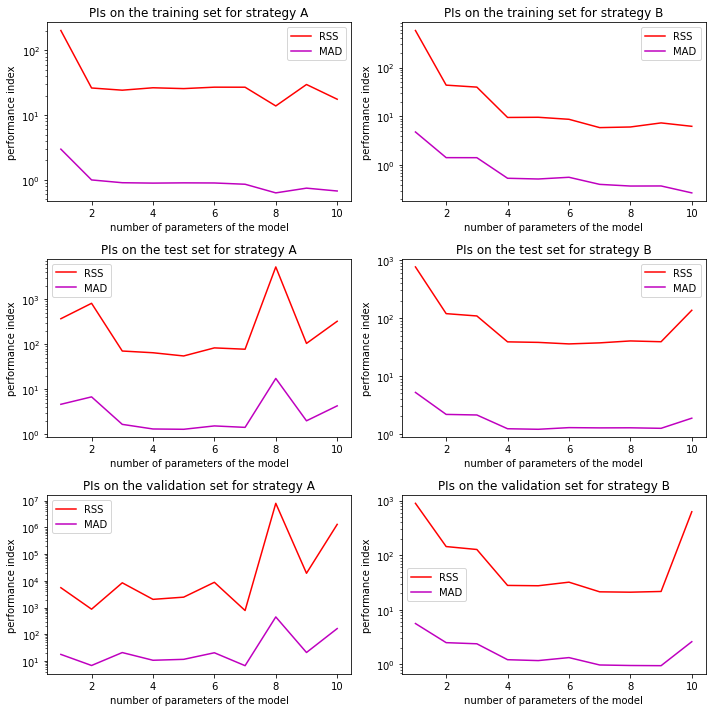

In [95]:
# plot the results
datasets   = [ 'training', 'test', 'validation' ]
splittings = [ 'A', 'B' ]

plt.figure(figsize=(10,10))

for c1, dataset in enumerate( datasets ):
    for c2, splitting in enumerate( splittings ):
        
        f = (c1) * len(splittings) + (c2+1)

        plt.subplot(3, 2, f)
        plt.plot(range(1, max_model_order), RSS[c1][c2][1:max_model_order], 'r', label = 'RSS')
        plt.plot(range(1, max_model_order), MAD[c1][c2][1:max_model_order], 'm', label = 'MAD')
#        plt.plot(range(1, max_model_order), FVU[c1][c2][1:max_model_order], 'b', label = 'FVU')
#        plt.plot(range(1, max_model_order), Rsq[c1][c2][1:max_model_order], 'k', label = 'R^2')
#        plt.plot(range(1, max_model_order), fit[c1][c2][1:max_model_order], 'g', label = 'fit')

        plt.xlabel('number of parameters of the model')
        plt.ylabel('performance index')
        plt.yscale('log')
        plt.legend()
        plt.title('PIs on the ' + dataset + ' set for strategy ' + splitting)

# set the spacing between subplots
plt.tight_layout()
plt.show()

# task 3.6

Assume the dataset refers to the trajectory that a robot follows in time (e.g., $u = $ time, and $y = $ position of the robot). Select:
1. what is in your opinion the most suitable strategy for splitting the whole dataset (i.e., among A and B) for this specific practical case;
2. which performance index seems most appropriate to the purpose of selecting the best estimator;
3. a strategy for solving the model order selection problem, i.e., selecting the best polynomial order among all the available ones;
4. a strategy for estimating of how well the estimator will perform in real life conditions.

Then plot the final estimator you get and print the estimated performance in real life conditions.

In [59]:
# perform the choices
# 1. => TODO
# 2. => TODO
# 3. => TODO
# 4. => TODO

# select the model order
selected_model_order = TODO

# recompute the estimates
theta_hat = TODO

# compute the estimated models
modeled_y = arbitrary_poly(theta_hat) # use the lambda function

# plot the true model against the measurements and the estimated model
x = np.linspace(start = min_u, stop = max_u, num = 100)
plt.figure()
plt.scatter(u, y,                 label = 'dataset')
plt.plot(x, noiseless_y(x), 'k:', label = 'true model')
plt.plot(x, modeled_y(x),   'b',  label = 'estimated model')
plt.xlabel('u')
plt.ylabel('y')
plt.legend();

# say which real life performance we expect to see
print('estimated performances in real life:')
print('RSS = ' + str(RSS[1][0][selected_model_order]))
print('MAD = ' + str(MAD[1][0][selected_model_order]))

NameError: name 'TODO' is not defined

# task 3.6

Motivate:

1. why you chose that specific way of splitting the dataset;
2. why you chose that specific performance index for choosing the model order;
3. why the way you estimate the performance indexes in real life conditions is a meaningful one.

Moreover:

4. Interpret the model order selection process in terms of overfitting / underfitting and bias vs variance tradeoff.

1. TODO

2. TODO

3. TODO

4. TODO